## <center>Amazon Stock Closing Price Forecast with Uncertainity</center>

<center><b>Menuka Jaiswal(mj9hre), Sneha Choudhary(sc4xc), Vidhi Gupta(vg5vc)</b></center>

In [1]:
## required packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.tsa.stattools as sts_tools
import statsmodels as sm
import statsmodels.api
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from scipy.stats import norm

### Load Data

In [2]:
## dates for which stock data will be collected
start = dt.datetime(2014, 1, 1)
end = dt.datetime(2019, 12, 7)

In [3]:
## amazon stocks
amzn = pdr.get_data_yahoo("AMZN", start = start, end = end, interval='d')
amzn

High          Low         Open        Close   Volume  \
Date                                                                      
2014-01-02   399.359985   394.019989   398.799988   397.970001  2137800   
2014-01-03   402.709991   396.220001   398.290009   396.440002  2210200   
2014-01-06   397.000000   388.420013   395.850006   393.630005  3170600   
2014-01-07   398.470001   394.290009   395.040009   398.029999  1916000   
2014-01-08   403.000000   396.040009   398.470001   401.920013  2316500   
...                 ...          ...          ...          ...      ...   
2019-12-02  1805.550049  1762.680054  1804.400024  1781.599976  3925600   
2019-12-03  1772.869995  1747.229980  1760.000000  1769.959961  3380900   
2019-12-04  1789.089966  1760.219971  1774.010010  1760.689941  2670100   
2019-12-05  1763.500000  1740.000000  1763.500000  1740.479980  2823800   
2019-12-06  1754.400024  1740.130005  1751.199951  1751.599976  3117400   

              Adj Close  
Date                     
2014-01-02   397.970001  
2014-01-03   396.440002  
2014-01-06   393.630005  
2014-01-07   398.029999  
2014-01-08   401.920013  
...                 ...  
2019-12-02  1781.599976  
2019-12-03  1769.959961  
2019-12-04  1760.689941  
2019-12-05  1740.479980  
2019-12-06  1751.599976  

[1494 rows x 6 columns]

#### Description:

- **Open** is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day).

- **High** is the highest price of the stock on that trading day.

- **Low** is the lowest price of the stock on that trading day.

- **Close** is the price of the stock at closing time. The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes.

- **Volume** indicates how many stocks were traded. 

- **Adj Close** is the updated stock closing price that accurately reflects the stock's value after accounting for any corporate actions. It is considered to be the true price of that stock and is often used when examining historical returns or performing a detailed analysis of historical returns.

### Exploratory Analysis

#### Candlestick Plot

In [4]:
candlestick = go.Candlestick(
    x = amzn.index,
    open = amzn['Open'],
    high = amzn['High'],
    low = amzn['Low'],
    close = amzn['Close']
)
fig = go.Figure(data=[candlestick])
fig.update_layout(title_text='Amazon (01/2014 - 12/2019)', xaxis_rangeslider_visible=True)
fig.show()

In the above candlestick plots:

- green candlestick indicates a day where the closing price was higher than the open (a gain)
- red candlestick indicates a day where the open was higher than the close (a loss)

#### Trends of Close Prices of the different Corporations

In [5]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=amzn.index, y=amzn['Adj Close'], line_color='darkturquoise'))
fig1.update_layout(title_text='Closing Prices of Amazon Stocks (01/2014 - 12/2019)', xaxis_rangeslider_visible=True)
fig1.show()

Amazon had a relatively consistent growth until 2018, followed by an increase in the closing prices mid 2018, which was then followed by a dip around year end, a slight increase and then another dip. It seems like these stock closing prices might be following mean reversion.

#### Trends of Stock Returns of the different Corporations

When trading, we are more concerned about the relative change of an asset rather than its absolute price.

In [6]:
## Daily returns in closing price
def add_daily_change_column(df, col_name):
    df['Daily Returns'] = df[col_name].pct_change()
    return df

amzn = add_daily_change_column(amzn, 'Adj Close')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=amzn.index, y=amzn['Daily Returns'], name="Amazon", line_color='darkturquoise'))
fig2.update_layout(title_text='Stock Returns (01/2014 - 12/2019)', xaxis_rangeslider_visible=True)
fig2.show()

The relative change in the daily stock prices seems to follow a white noise (stationary distribution). Conducting an augmented dickey-fullter test on this series can confirm if we can assume this is a stationary distribution.

#### AutoCorrelation in Closing Prices

In [7]:
## Augmented Dickey-Fuller Test
adfuller = sts_tools.adfuller(amzn['Daily Returns'][1:], maxlag = 1)
## ADF p-value
adfuller[1]

0.0

As the p-value of the ADF hypothesis test is less than 0.05, we have enough statistical evidence to reject the null hypothesis and conclude that the relative change in closing prices is stationary.

**Note:** The p-value is not exactly 0 but a very very small number, but due to round-off precision error in python it is outputted as 0

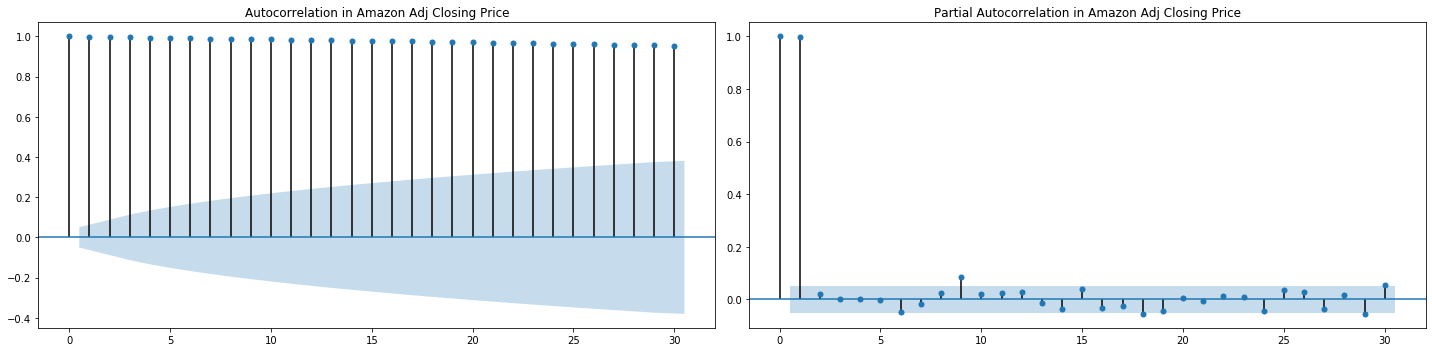

In [8]:
max_lags = 30
fig, axes = plt.subplots(1, 2, figsize=(20,5))

plot_acf(amzn['Adj Close'], alpha=0.05, lags=max_lags, ax = fig.axes[0], title = 'Autocorrelation in Amazon Adj Closing Price')
plot_pacf(amzn['Adj Close'], alpha=0.05, lags=max_lags, ax = fig.axes[1], title = 'Partial Autocorrelation in Amazon Adj Closing Price')

fig.tight_layout()

Autocorrelation is a measure of the correlation in a time-series with a lagged version of itself.

Partial Autocorrelation is similar to autocorrelation, however it removes the effects of previous time points. For instance, for autocorrelation of order=3, parital autocorrelation would remove the effects of lags 1 and 2. Hence, partial autocorrelation can provide us with the order of the AutoRegressive Model for the time-series, as it tells us on how many previous steps does the current value depend on.

From the above plots we can see that our time series for all 3 companies have significant autocorrelation for all 50 lags as the autocorrelation from previous lag is being propagated, however with partial autocorrelation the lag is 1. 

#### Seasonality Trends

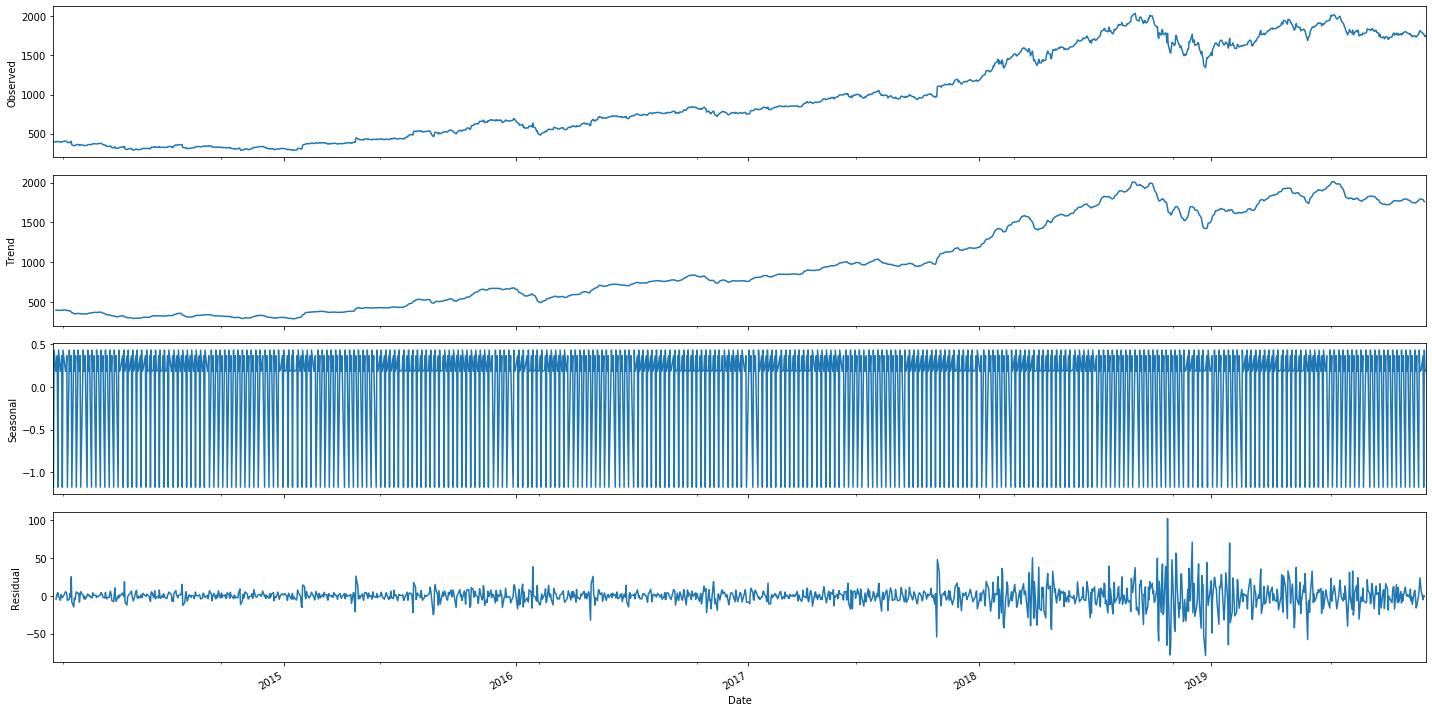

In [9]:
plt.rcParams['figure.figsize'] = 20, 10

res = sm.tsa.seasonal.seasonal_decompose(amzn['Adj Close'], model='additive', freq=5) ## weekly seasonality
res.plot()
plt.show()

### Modeling

In [10]:
SEED = 684

## Build structural time series model
## Includes components for local linear trend, weekly seasonality and autoregressive model
def build_model(observed_time_series, lags, observation_noise_scale_prior):
    linear_trend = tfp.sts.LocalLinearTrend(
        observed_time_series = observed_time_series
    )
    
    dayofweek_season = tfp.sts.Seasonal(
        num_seasons = 5,
        num_steps_per_season = 1,
        observed_time_series = observed_time_series, 
        constrain_mean_effect_to_zero = False,
        name = "dayofweek_season"
    )

    autoregressive = tfp.sts.Autoregressive(
        order = lags,
        observed_time_series = observed_time_series
    )

    model = tfp.sts.Sum(
        [dayofweek_season, linear_trend, autoregressive], 
        observed_time_series = observed_time_series,
        observation_noise_scale_prior = observation_noise_scale_prior
    )
    return model

## To fit the model to data, we define a surrogate posterior and 
## fit it by minimizing the negative variational evidence lower bound (ELBO)
def fit_variational_posterior(model, variational_posteriors, observed_time_series):
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn = model.joint_log_prob(observed_time_series = observed_time_series),
        surrogate_posterior = variational_posteriors,
        optimizer = tf.optimizers.Adam(learning_rate = 0.1),
        num_steps = 100,
        seed = SEED
    )
    return elbo_loss

## Plot ELBO curve
def plot_elbo_loss(elbo_loss):
    fig = go.Figure(data=go.Scatter(x = np.arange(len(elbo_loss)), y = elbo_loss))
    fig.update_layout(title_text='ELBO Plot')
    fig.update_xaxes(title_text='Number of Iterations')
    fig.update_yaxes(title_text='-ve ELBO')
    fig.show()
    
## Forecast for `num_forecast_steps` days
def forecast(model, samples, observed_time_series, num_forecast_steps):
    forecast_dist = tfp.sts.forecast(
        model, 
        observed_time_series = observed_time_series, 
        parameter_samples = samples,
        num_steps_forecast = num_forecast_steps
    )
    forecast_mean = forecast_dist.mean().numpy().flatten()
    forecast_std = forecast_dist.stddev().numpy().flatten()
    return {'mean': forecast_mean, 'scale': forecast_std}

## Forecast the next 20 days using one-step-prediction which will give 
## predictive distribution over observations at each time T, given observations up through time T-1.
def forecast_onestep_prediction(model, samples, observed_time_series, num_forecast_steps):
    forecast_dist = tfp.sts.one_step_predictive(
        model, 
        observed_time_series = observed_time_series, 
        parameter_samples = samples
    )
    forecast_mean = forecast_dist.mean().numpy()[-num_forecast_steps:]
    forecast_std = forecast_dist.stddev().numpy()[-num_forecast_steps:]
    return {'mean': forecast_mean, 'scale': forecast_std}

## Plot Forecast
def plot_forecast(actual_dates, actual, forecast_dates, prediction, prediction_uncertainity, title='Forecast'):
    prediction_lb = prediction - 1.96*prediction_uncertainity
    prediction_ub = prediction + 1.96*prediction_uncertainity
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=actual_dates, 
        y=actual, 
        name='Ground Truth',
        mode='lines+markers',
        line_color='darkturquoise'
    ))
    fig.add_trace(go.Scatter(
        x=forecast_dates, 
        y=prediction, 
        name='Forecast', 
        mode='lines+markers',
        line_color='orange'
    ))
    fig.add_trace(go.Scatter(
        x = forecast_dates,
        y = prediction_ub,
        fill = None,
        mode='lines',
        line_color='orange',
        showlegend=False,
        name='Forecast UB'
    ))
    fig.add_trace(go.Scatter(
        x = forecast_dates,
        y = prediction_lb,
        fill='tonexty',
        mode='lines', 
        line_color='orange',
        showlegend=False,
        name='Forecast LB'
    ))
    fig.update_layout(title_text=title, xaxis_rangeslider_visible=True)
    fig.show()
    
## Extract inferred value of model Parameters
def extract_model_params(model, samples):
    model_params = {}
    for param in model.parameters:
        model_params[param.name] = {
            "point_estimate": np.mean(samples[param.name], axis=0),
            "uncertainity": np.std(samples[param.name], axis=0)
        }
    return pd.DataFrame.from_dict(model_params).T

In [11]:
## Number of days to be forecasted
num_forecast_steps = 20

## Extract training data
amzn_data = amzn['Adj Close']
amzn_train_data = amzn_data[:-num_forecast_steps]
amzn_train_data_len = len(amzn_train_data)

## Extract noise scale prior for observation noise from the closing price using daily returns
# noise_scale = amzn['Daily Returns'].std()
# noise_scale_prior = tfp.distributions.Normal(np.float64(0.0), np.float64(1.0))

In [12]:
## Build Model
model_lag1 = build_model(amzn_train_data, 1, None)

## Build variational surrogate posterior
variational_posteriors_lag1 = tfp.sts.build_factored_surrogate_posterior(model = model_lag1, seed = SEED)

## To fit the model to data, we define a surrogate posterior and 
## fit it by minimizing the negative variational evidence lower bound (ELBO)
elbo_loss_lag1 = fit_variational_posterior(model_lag1, variational_posteriors_lag1, amzn_train_data)

## Plot ELBO
plot_elbo_loss(elbo_loss_lag1)

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


In [13]:
## Draw samples from posterior
samples_lag1 = variational_posteriors_lag1.sample(1000)

In [14]:
model_params = extract_model_params(model_lag1, samples_lag1)
model_params

point_estimate            uncertainity
observation_noise_scale                     2.75188                0.732038
dayofweek_season/_drift_scale               1.82073               0.0907304
LocalLinearTrend/_level_scale                7.5679                0.535529
LocalLinearTrend/_slope_scale              0.587628               0.0699878
Autoregressive/_coefficients   [0.9311705631955051]  [0.041593167040223394]
Autoregressive/_level_scale                 18.4062                0.474753

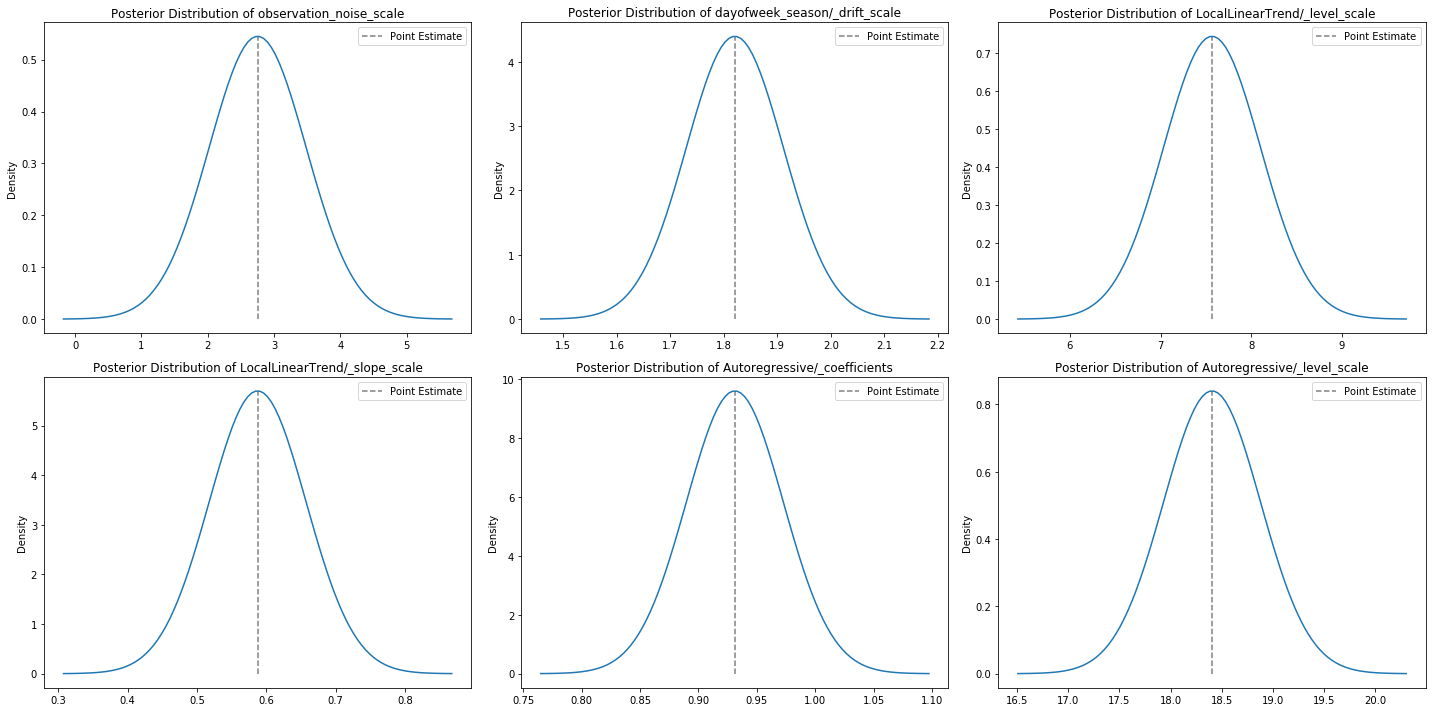

In [15]:
fig, axes = plt.subplots(2, 3)
for param, loc, scale, ax in zip(model_params.index, model_params['point_estimate'], model_params['uncertainity'], fig.axes):
    x = np.linspace(loc - 4*scale, loc + 4*scale, 100)
    y = norm.pdf(x, loc, scale)
    ax.plot(x, y)
    ax.vlines(loc, 0, max(y), linestyles = 'dashed', color = 'grey', label='Point Estimate')
    ax.set_title('Posterior Distribution of {}'.format(param))
    ax.set_ylabel('Density')
    ax.legend()
fig.tight_layout()

### Forecasting

In [16]:
## Forecast next 20 days
forecast_params_lag1 = forecast(model_lag1, samples_lag1, amzn_train_data, num_forecast_steps)

In [17]:
## Plot Forecast
actual = amzn_data
actual_dates = actual.index
forecast_dates = actual.index[-num_forecast_steps:]
plot_forecast(
    actual_dates, actual, 
    forecast_dates, forecast_params_lag1['mean'], forecast_params_lag1['scale'], 
    'Amazon Stock Closing Price Forecast for next 20 days'
)

In [18]:
## Plot Forecast
actual = amzn_data[amzn_train_data_len-20:]
actual_dates = actual.index
forecast_dates = actual.index[-num_forecast_steps:]
plot_forecast(
    actual_dates, actual, 
    forecast_dates, forecast_params_lag1['mean'], forecast_params_lag1['scale'], 
    'Amazon Stock Closing Price Forecast for next 20 days'
)

In [19]:
## Forecast Estimates and their uncertainity
n_step_forecast = pd.DataFrame(columns = ['Date', 'Actual Value','Forecast Estimate','Forecast Uncertainty'])
n_step_forecast['Date'] = actual[-num_forecast_steps:].index
n_step_forecast['Actual Value'] = actual[-num_forecast_steps:].values
n_step_forecast['Forecast Estimate'] = forecast_params_lag1['mean']
n_step_forecast['Forecast Uncertainty'] = forecast_params_lag1['scale']
n_step_forecast

Date  Actual Value  Forecast Estimate  Forecast Uncertainty
0  2019-11-08   1785.880005        1783.701873             22.092446
1  2019-11-11   1771.650024        1784.763535             30.404435
2  2019-11-12   1778.000000        1778.036269             36.824920
3  2019-11-13   1753.109985        1782.877778             42.243184
4  2019-11-14   1754.599976        1784.882468             46.799584
5  2019-11-15   1739.489990        1780.446160             51.990142
6  2019-11-18   1752.530029        1781.720052             56.462684
7  2019-11-19   1752.790039        1775.183676             60.629875
8  2019-11-20   1745.530029        1780.197255             64.554738
9  2019-11-21   1734.709961        1782.357371             68.118637
10 2019-11-22   1745.719971        1778.061726             72.343847
11 2019-11-25   1773.839966        1779.463158             76.171950
12 2019-11-26   1796.939941        1773.042627             79.864919
13 2019-11-27   1818.510010        1778.161604             83.440185
14 2019-11-29   1800.800049        1780.417767             86.772499
15 2019-12-02   1781.599976        1776.209784             90.728851
16 2019-12-03   1769.959961        1777.691343             94.391681
17 2019-12-04   1760.689941        1771.344154             97.976412
18 2019-12-05   1740.479980        1776.530355            101.488288
19 2019-12-06   1751.599976        1778.848216            104.806836

In [20]:
## Forecast next 20 days via one-step prediction
onestep_forecast_params_lag1 = forecast_onestep_prediction(model_lag1, samples_lag1, amzn_data, num_forecast_steps)

In [21]:
## Plot Forecast
actual = amzn_data[amzn_train_data_len-20:]
actual_dates = actual.index
forecast_dates = actual.index[-num_forecast_steps:]
plot_forecast(
    actual_dates, actual, 
    forecast_dates, onestep_forecast_params_lag1['mean'], onestep_forecast_params_lag1['scale'], 
    'Amazon Stock Closing Price Forecast(via one-step prediction) for next 20 days'
)

In [22]:
## Plot Forecast
actual = amzn_data
actual_dates = actual.index
forecast_dates = actual.index[-num_forecast_steps:]
plot_forecast(
    actual_dates, actual, 
    forecast_dates, onestep_forecast_params_lag1['mean'], onestep_forecast_params_lag1['scale'], 
    'Amazon Stock Closing Price Forecast(via one-step prediction) for next 20 days'
)

In [23]:
## One step Forecast Estimates and their uncertainity
one_step_forecast = pd.DataFrame(columns = ['Date', 'Actual Value','Forecast Estimate','Forecast Uncertainty'])
one_step_forecast['Date'] = actual[-num_forecast_steps:].index
one_step_forecast['Actual Value'] = actual[-num_forecast_steps:].values
one_step_forecast['Forecast Estimate'] = onestep_forecast_params_lag1['mean']
one_step_forecast['Forecast Uncertainty'] = onestep_forecast_params_lag1['scale']
one_step_forecast

Date  Actual Value  Forecast Estimate  Forecast Uncertainty
0  2019-11-08   1785.880005        1783.701873             22.092446
1  2019-11-11   1771.650024        1786.822206             22.094599
2  2019-11-12   1778.000000        1765.732565             22.094166
3  2019-11-13   1753.109985        1782.248335             22.091238
4  2019-11-14   1754.599976        1756.643155             22.101789
5  2019-11-15   1739.489990        1751.038501             22.101978
6  2019-11-18   1752.530029        1739.452909             22.105541
7  2019-11-19   1752.790039        1747.970052             22.095287
8  2019-11-20   1745.530029        1753.923015             22.093960
9  2019-11-21   1734.709961        1748.953983             22.094392
10 2019-11-22   1745.719971        1730.189845             22.105156
11 2019-11-25   1773.839966        1745.934688             22.092257
12 2019-11-26   1796.939941        1768.660905             22.092699
13 2019-11-27   1818.510010        1795.799913             22.105496
14 2019-11-29   1800.800049        1818.160600             22.122688
15 2019-12-02   1781.599976        1797.525202             22.098557
16 2019-12-03   1769.959961        1785.256267             22.093868
17 2019-12-04   1760.689941        1769.005904             22.091541
18 2019-12-05   1740.479980        1764.054468             22.094015
19 2019-12-06   1751.599976        1740.953035             22.110169

In [24]:
## Calculate absolute cumulative error of forecasts
error_values_onestep = pd.Series(
    abs(onestep_forecast_params_lag1['mean'] - actual[-num_forecast_steps:].values)
)
cumsum_onestep = error_values_onestep.cumsum() 

error_values = pd.Series(
    abs(forecast_params_lag1['mean'] - actual[-num_forecast_steps:].values)
)
cumsum = error_values.cumsum()

In [26]:
## Tablular disply of absolute cumulative error of forecast
columns = ['Actual Value','One Step Prediction','N Step Prediction','One Step Error', 'N Step Error']
error_analysis_df = pd.DataFrame(columns= columns)
error_analysis_df['Actual Value'] = actual[-num_forecast_steps:].values
error_analysis_df['One Step Prediction'] = onestep_forecast_params_lag1['mean'] 
error_analysis_df['N Step Prediction'] = forecast_params_lag1['mean']
error_analysis_df['One Step Error'] = cumsum_onestep
error_analysis_df['N Step Error'] = cumsum
error_analysis_df

Actual Value  One Step Prediction  N Step Prediction  One Step Error  \
0    1785.880005          1783.701873        1783.701873        2.178132   
1    1771.650024          1786.822206        1784.763535       17.350313   
2    1778.000000          1765.732565        1778.036269       29.617748   
3    1753.109985          1782.248335        1782.877778       58.756098   
4    1754.599976          1756.643155        1784.882468       60.799278   
5    1739.489990          1751.038501        1780.446160       72.347788   
6    1752.530029          1739.452909        1781.720052       85.424908   
7    1752.790039          1747.970052        1775.183676       90.244895   
8    1745.530029          1753.923015        1780.197255       98.637881   
9    1734.709961          1748.953983        1782.357371      112.881903   
10   1745.719971          1730.189845        1778.061726      128.412029   
11   1773.839966          1745.934688        1779.463158      156.317306   
12   1796.939941          1768.660905        1773.042627      184.596343   
13   1818.510010          1795.799913        1778.161604      207.306440   
14   1800.800049          1818.160600        1780.417767      224.666991   
15   1781.599976          1797.525202        1776.209784      240.592218   
16   1769.959961          1785.256267        1777.691343      255.888524   
17   1760.689941          1769.005904        1771.344154      264.204487   
18   1740.479980          1764.054468        1776.530355      287.778974   
19   1751.599976          1740.953035        1778.848216      298.425915   

    N Step Error  
0       2.178132  
1      15.291643  
2      15.327912  
3      45.095704  
4      75.378196  
5     116.334365  
6     145.524388  
7     167.918026  
8     202.585252  
9     250.232661  
10    282.574417  
11    288.197609  
12    312.094924  
13    352.443330  
14    372.825612  
15    378.215804  
16    385.947186  
17    396.601398  
18    432.651772  
19    459.900013

In [25]:
## Plot absolute cumulative error of forecast
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=np.arange(len(cumsum_onestep)), 
    y=cumsum_onestep, 
    line_color='darkturquoise', 
    name = 'One Step Prediction', 
    mode='lines+markers'
))
fig3.add_trace(go.Scatter(
    x=np.arange(len(cumsum)), 
    y=cumsum, line_color='red', 
    name = 'N Step Prediction', 
    mode='lines+markers'
))
fig3.update_layout(title_text='Cumulative Absolute Prediction Error')
fig3.update_xaxes(title_text='Days')
fig3.update_yaxes(title_text='Cumulative Error')
fig3.show()

One-step-ahead predicitve strategy gives better estimates than N-step. 